In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from glob import glob
import os
import TOC_functions
%matplotlib widget

In [38]:
root_folder = os.path.expanduser('C:/Users/ica/OneDrive - Plymouth Marine Laboratory/vscode/TOC_analysis/data/2025/01')  # yourpath
picarro_df = TOC_functions.merge_picarro_files(root_folder)
picarro_df = TOC_functions.qc(picarro_df)


In [39]:
# filter by time

start_time = datetime.datetime(2025, 1, 17, 16, 5, 0)
end_time = datetime.datetime(2025, 1, 17, 16, 15, 0)

In [40]:
#picarro_df.set_index('datetime', inplace=True)

df = picarro_df.loc[start_time:end_time]

TypeError: '<' not supported between instances of 'int' and 'datetime.datetime'

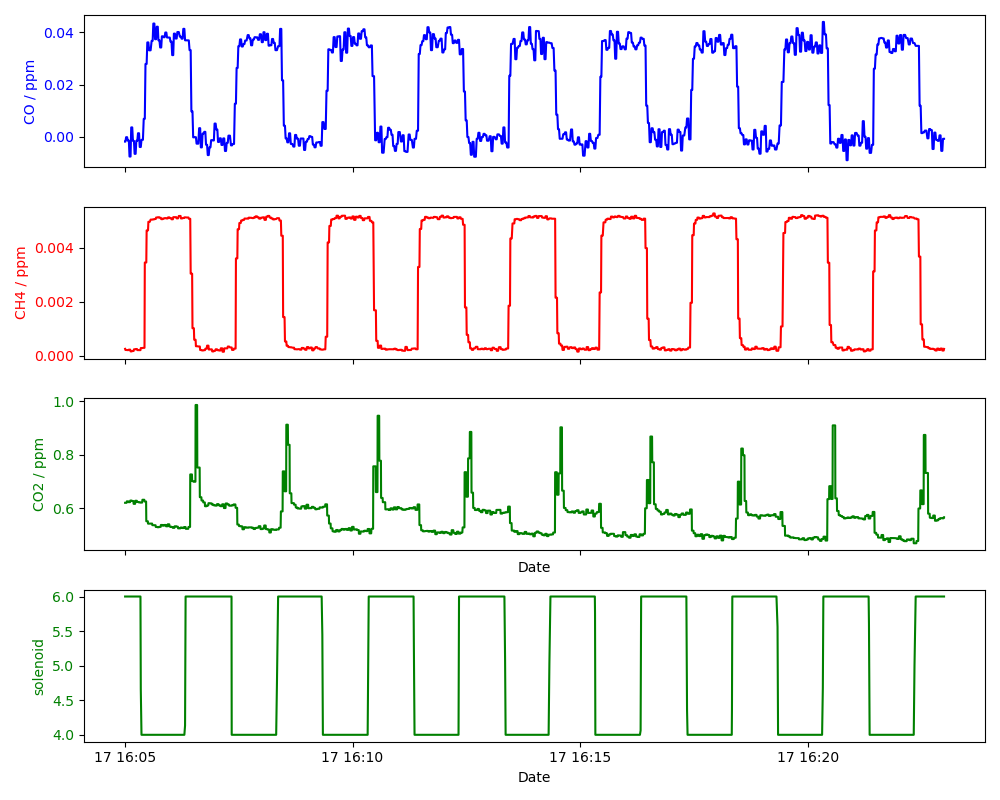

In [23]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, sharex=True, figsize=(10, 8))

# Plot for CO
ax1.plot(df.index, df.CO, label='CO / ppm', color='blue')
ax1.set_ylabel('CO / ppm', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot for CH4
ax2.plot(df.index, df.CH4, label='CH4 / ppm', color='red')
ax2.set_ylabel('CH4 / ppm', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Plot for CO2
ax3.plot(df.index, df.CO2, label='CO2 / ppm', color='green')
ax3.set_xlabel('Date')
ax3.set_ylabel('CO2 / ppm', color='green')
ax3.tick_params(axis='y', labelcolor='green')

ax4.plot(df.index, df.solenoid_valves, label='', color='green')
ax4.set_xlabel('Date')
ax4.set_ylabel('solenoid', color='green')
ax4.tick_params(axis='y', labelcolor='green')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [45]:

df = TOC_functions.qc(df)

def TOC_df_blank(df):
    """
    Makes df for TOC calculations, averages catalyst and ambient times
    
    Args:
        df: df with qc measurements
    
    Returns:
        df to do TOC calculations 
    """
    # lists for storing averages
    avg_times = []
    avg_co2_ambient = []
    avg_co2_catalyst = []
    avg_ch4_ambient = []
    avg_ch4_catalyst = []
    avg_co_ambient = []
    avg_co_catalyst = []

    # detect for valve changes
    valve_change = df[(df['solenoid_valves'] !=6.0) & (df['solenoid_valves'] != 4.0)]  # valve =2 is catalyst
                                                                                       # valve = 0 is ambient

    # averages before valve changes
    for i in valve_change.index:
        #  time window (25s before valve change, ending 2s before)
        end_time = i - pd.Timedelta(seconds=2)
        start_time = end_time - pd.Timedelta(seconds=42)
        
        # get data in the main df within time window
        window_df = df[(df.index > start_time) & (df.index < end_time)]
        
        # averages
        avg_co2 = window_df['CO2_corrected'].mean()
        avg_ch4 = window_df['CH4_corrected'].mean()
        avg_co = window_df['CO'].mean()
        avg_valve = window_df['solenoid_valves'].mean()
        avg_time_val = window_df.index.mean()
        avg_times.append(avg_time_val)

        # sort appropriate lists based on valve state
        if avg_valve == 6.0:  # catalyst
            avg_co2_catalyst.append(avg_co2)
            avg_ch4_catalyst.append(avg_ch4)
            avg_co_catalyst.append(avg_co)
            avg_co2_ambient.append(np.nan)
            avg_ch4_ambient.append(np.nan)
            avg_co_ambient.append(np.nan)
        elif avg_valve == 4.0:  # ambient
            avg_co2_ambient.append(avg_co2)
            avg_ch4_ambient.append(avg_ch4)
            avg_co_ambient.append(avg_co)
            avg_co2_catalyst.append(np.nan)
            avg_ch4_catalyst.append(np.nan)
            avg_co_catalyst.append(np.nan)

    # create results df
    TOC_df = pd.DataFrame({
        'datetime': avg_times,
        'avg_co2_ambient': avg_co2_ambient,
        'avg_ch4_ambient': avg_ch4_ambient,
        'avg_co_ambient': avg_co_ambient,
        'avg_co2_catalyst': avg_co2_catalyst,
        'avg_ch4_catalyst': avg_ch4_catalyst,
        'avg_co_catalyst': avg_co_catalyst
    })

    return TOC_df.set_index('datetime')

In [46]:
df = TOC_functions.qc(df)
# TOC averages
TOC_df = TOC_df_blank(df)

# calculate final TOC
toc = TOC_functions.calculate_toc(TOC_df)
toc = toc[:-1]

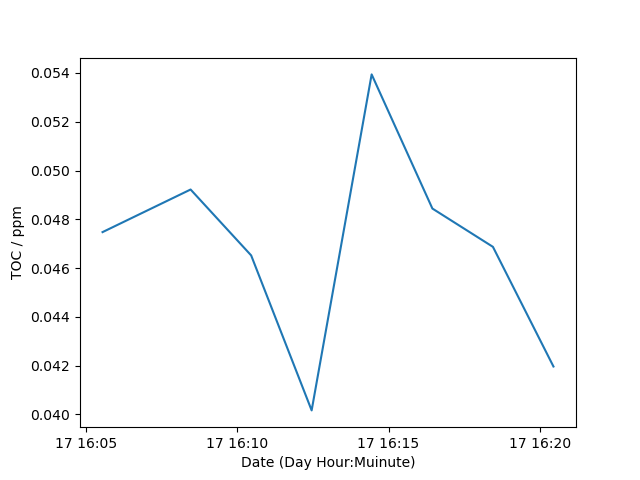

In [48]:
plt.figure()
plt.plot(toc.index, toc['TOC'])
plt.ylabel('TOC / ppm')
plt.xlabel('Date (Day Hour:Muinute)')
plt.show()

In [49]:
toc.mean()

TOC    0.046823
dtype: float64